# Restaurant Rate Predction

- this repo includes insightful data analysis and visualizations on cafes and restaurants which are reviewed and rated on database in Bangkok.
- Rate column is the target column and we will create regression model pipelines to get best results
- Reviews_list column will be handled seperately by NLP to analye restaurants deeply


In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import random
# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objs as go
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster
from tqdm import tqdm
from plotly import tools
import re
from plotly.offline import init_notebook_mode, plot, iplot


### PrePro

#### read

In [2]:
df = pd.read_csv('./dbs/zomato.csv')

In [3]:
df.info()
# we can fill nulls in location column with adress column info and also fill rates with rates in review_list rates 
# dish liked nulls fill be filled with None value to imply nothing we can't drop null values in the column
# url adress phone columns are useless for our analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [4]:
df = df.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type',
                                  'listed_in(city)':'city'})

In [5]:
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,type,city
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


#### drop unnecssary columns

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
drop_cols = ['url','phone','address']
df = df.drop(columns=drop_cols,axis=1)

#### Deal with NaN values

In [16]:
df.isna().sum()
# since our target is rate column, we can utilize rates in reviews_list column and fill nan values with average value in reviews_list, 

name                0
online_order        0
book_table          0
rate             7775
votes               0
location           21
rest_type         227
dish_liked      28078
cuisines           45
cost              346
reviews_list        0
menu_item           0
type                0
city                0
dtype: int64

#### Deal columns one by one

##### menu_item


In [8]:
df['menu_item'].loc[df['menu_item'] != '[]'].count()
# nearly 4/5 of columns don't have menu item we can fill it with dish_liked and foods that refered in reviews_list

12100

In [9]:
df['menu_item'].loc[df['menu_item'] != '[]'].iloc[1]

"['Chole Kulcha Meal', 'Upvas Aloo Paratha With Dahi', 'Singhada Aloo Paratha with Hare Tamatar Ki Sabji', 'Smoked Butter Chicken Combo', 'Paneer Methi Chaman Combo', 'Mutton Bhuna Combo', 'Rajma Masala Meal', 'Dal Makhani Veg Starter Combo', 'Dal Makhani Non-Veg Starter Combo', 'Malai Kofta Combo', 'Jumbo Chicken Wrap', 'Jumbo Veg Wrap', 'Jumbo Falafel Salsa Wrap', 'Chicken Overload Jumbo Wrap', 'Veg Pizza Wrap', 'Chicken Pizza Wrap', 'Mexican Potato Salsa Wrap', 'American Smokey Sausage Wrap', 'Makhani Falafel Wrap', 'Mutton Overload Wrap', 'Mac & Cheese Chicken Wrap', 'Mac & Cheese Veg Wrap', 'Barbeque Chicken Wrap', 'Mutton Boti Wrap', 'Masala Paneer Tikka Wrap', 'Fiery Paneer Tikka Wrap', 'Masala Chicken Tikka Wrap', 'Cheesy Corn Salsa Wrap', 'Chicken Mayo Wrap', 'Cheese Melt Chicken Wrap', 'Cheese Melt Paneer Wrap', 'Double Cheese Meatball Wrap', 'Reshmi Chicken Kebab Wrap', 'Egg Cheese Sausage Wrap', 'Double Egg Chatpata Wrap', 'Cheesy Potato Wrap', 'Veg Falafel Wrap', 'Chicken 

In [10]:
df['dish_liked'].loc[df['dish_liked'] != '[]'].count()

23639

In [11]:
empty_menu_dish = df['dish_liked'].loc[df['menu_item'] == '[]']
nan_dishes_menu = df['menu_item'].loc[pd.isnull(df['dish_liked'])]

In [12]:
empty_menu_dish.isna().sum()

22830

In [13]:
len(empty_menu_dish)

39617

In [56]:
# wecan fill aroind 15000 menu item row with dish liked and can check food names in reviews_list

We will going to append all unique foods in dish liked and menu item, goin to scan those names in reviews_list and if we coinciding with any of them we will append it to the menu item value of the correspending row

In [14]:
for dish in df['dish_liked'][:10]:
    print(dish)

Pasta, Lunch Buffet, Masala Papad, Paneer Lajawab, Tomato Shorba, Dum Biryani, Sweet Corn Soup
Momos, Lunch Buffet, Chocolate Nirvana, Thai Green Curry, Paneer Tikka, Dum Biryani, Chicken Biryani
Churros, Cannelloni, Minestrone Soup, Hot Chocolate, Pink Sauce Pasta, Salsa, Veg Supreme Pizza
Masala Dosa
Panipuri, Gol Gappe
Onion Rings, Pasta, Kadhai Paneer, Salads, Salad, Roti, Jeera Rice
nan
Farmhouse Pizza, Chocolate Banana, Virgin Mojito, Pasta, Paneer Tikka, Lime Soda, Prawn Pizza
Pizza, Mocktails, Coffee, Nachos, Salad, Pasta, Sandwiches
Waffles, Pasta, Coleslaw Sandwich, Choco Waffle, Tacos, Momos, Cheese Nachos


In [15]:
df.dish_liked = df.dish_liked.apply(lambda x:x.lower().strip() if isinstance(x,str) else x)
df.menu_item = df.menu_item.apply(lambda x:x.lower().strip() if isinstance(x,str) else x)

In [16]:
foods_in_dished_like = df['dish_liked']
foods_in_dished_like.dropna(inplace=True)
foods_in_dished_like_column = [dish.split(',') for dish in foods_in_dished_like]

In [17]:
foods_in_menu_item = df['menu_item'].loc[df['menu_item'] != '[]']
foods_in_menu_item.dropna(inplace=True)
foods_in_menu_item_column = [dish.split(',') for dish in foods_in_menu_item]

In [18]:
merged_food_list = foods_in_dished_like_column+ foods_in_menu_item_column

In [19]:
food_list = []
for i in range(len(merged_food_list)):
    for j in range(len(merged_food_list[i])):
        food_list.append(merged_food_list[i][j])

In [20]:
food_list = set(food_list)

In [21]:
len(food_list)
# we got our food list now

143895

In [22]:
food_listt = food_list

In [226]:
# food_listt =     map(lambda x : x.strip().lower(),food_listt)
# food_listt  = list(food_listt)
# food_listt = set(food_listt)

In [23]:
df2= df.copy()

In [24]:
import unicodedata

In [25]:
df['reviews_list'] = df['reviews_list'].apply(lambda val: unicodedata.normalize('NFKD', val).encode('ascii', 'ignore').decode())

In [26]:
df['reviews_list'] = [i.replace("RATED\\n  ",'').replace('\\n','').replace('�','').replace('?','').replace('\n','').strip().lower() for i in df.reviews_list]

In [27]:
food_list.intersection(df.reviews_list[1000].split(' '))

{'biryani', 'buttermilk', 'chicken', 'rice'}

In [28]:
df['dish_n_reviews'] = df.reviews_list.apply(lambda x: ', '.join(list(food_list.intersection(x.split(' ')))))

In [29]:
df.dish_n_reviews[:5]

0         paratha, chaap, chicken, halwa, breads, rice
1    biryani, roti, momos, chicken, lassi, fish, ri...
2    pizza, pasta, decor, nachos, cheesecake, churr...
3                               vegetarian, roti, rice
4                                      paratha, kulcha
Name: dish_n_reviews, dtype: object

Nearly 80 % of the menu item values is [] this is extremely high, maybe we can add menu items from reviews_list and dish liked

In [30]:
df['dish_liked'].iloc[1500]

nan

In [31]:
df.query('dish_liked != dish_liked')[['dish_liked','dish_n_reviews']].sample(5,random_state=1)

,dish_liked,dish_n_reviews
9076,NaN,
39058,NaN,"rolls, chicken, vada"
1147,NaN,
3142,NaN,
2104,NaN,"biryani, lemonade, chicken, salad, rice, tikka"


In [32]:
nan_index = df.query('dish_liked != dish_liked & dish_n_reviews == dish_n_reviews').index
for i in nan_index:
    df.loc[i,'dish_liked'] = df.loc[i,'dish_n_reviews']

In [33]:
df['dish_liked'].isna().sum()
# nice job

0

In [34]:
df.drop(columns=['dish_n_reviews'],axis=1,inplace=True)

In [35]:
df[:1]

,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,type,city
0,Jalsa,Yes,Yes,4.1/5,775,Banashankari,Casual Dining,"pasta, lunch buffet, masala papad, paneer laja...","North Indian, Mughlai, Chinese",800,"[('rated 4.0', 'a beautiful place to dine in.t...",[],Buffet,Banashankari


##### Reviews_list
we will check nan values in rate column and try to fill them with rates in reviews_list if rate is null and reviews_list != []

we will drop the row if reviews_list = [] and rate is nan

After filling rate, we are going to clean text in the column and create new database with reviews_list and rates to work on it independently with gensim model.

In [36]:
df2= df.copy()

### Fill Empty Rates from reviews_list rates

In [47]:
df2 = df.copy()

In [48]:
prr = df2[df2['rate'].isna()]

In [49]:
prr[prr['reviews_list'] != '[]'].count()
# we can fill 2501 of nan rate

name            2501
online_order    2501
book_table      2501
rate               0
votes           2501
location        2501
rest_type       2492
dish_liked      2501
cuisines        2495
cost            2452
reviews_list    2501
menu_item       2501
type            2501
city            2501
dtype: int64

In [51]:
indi  = prr[prr['reviews_list'] == '[]' ].index
df2.drop(indi,inplace=True)

In [52]:
df2[df2['rate'].isna()].count()

name            2501
online_order    2501
book_table      2501
rate               0
votes           2501
location        2501
rest_type       2492
dish_liked      2501
cuisines        2495
cost            2452
reviews_list    2501
menu_item       2501
type            2501
city            2501
dtype: int64

In [53]:
df2.reset_index(drop=True)

,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,type,city
0,Jalsa,Yes,Yes,4.1/5,775,Banashankari,Casual Dining,"pasta, lunch buffet, masala papad, paneer laja...","North Indian, Mughlai, Chinese",800,"[('rated 4.0', 'a beautiful place to dine in.t...",[],Buffet,Banashankari
1,Spice Elephant,Yes,No,4.1/5,787,Banashankari,Casual Dining,"momos, lunch buffet, chocolate nirvana, thai g...","Chinese, North Indian, Thai",800,"[('rated 4.0', 'had been here for dinner with ...",[],Buffet,Banashankari
2,San Churro Cafe,Yes,No,3.8/5,918,Banashankari,"Cafe, Casual Dining","churros, cannelloni, minestrone soup, hot choc...","Cafe, Mexican, Italian",800,"[('rated 3.0', ""ambience is not that good enou...",[],Buffet,Banashankari
3,Addhuri Udupi Bhojana,No,No,3.7/5,88,Banashankari,Quick Bites,masala dosa,"South Indian, North Indian",300,"[('rated 4.0', ""great food and proper karnatak...",[],Buffet,Banashankari
4,Grand Village,No,No,3.8/5,166,Basavanagudi,Casual Dining,"panipuri, gol gappe","North Indian, Rajasthani",600,"[('rated 4.0', 'very good restaurant in neighb...",[],Buffet,Banashankari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46438,Topsy Turvey,No,No,NaN,0,Whitefield,Bar,vegetarian,Finger Food,900,"[('rated 4.0', ""a divine joint for flavourful ...",[],Pubs and bars,Whitefield
46439,Bhagini,No,No,2.5 /5,81,Whitefield,"Casual Dining, Bar","biryani, andhra meal","Andhra, South Indian, Chinese, North Indian",800,"[('rated 4.0', 'a fine place to chill after of...",[],Pubs and bars,Whitefield
46440,Best Brews - Four Points by Sheraton Bengaluru...,No,No,3.6 /5,27,Whitefield,Bar,"mocktails, chicken, cocktails",Continental,"1,500","[('rated 5.0', ""food and service are incompara...",[],Pubs and bars,Whitefield
46441,Chime - Sheraton Grand Bengaluru Whitefield Ho...,No,Yes,4.3 /5,236,"ITPL Main Road, Whitefield",Bar,"cocktails, pizza, buttermilk",Finger Food,"2,500","[('rated 4.0', 'nice and friendly place and st...",[],Pubs and bars,Whitefield


In [54]:
df2['rate'].isna().value_counts()
# we are going to fill this 2501 rate row now

False    43942
True      2501
Name: rate, dtype: int64

In [55]:
pat = re.compile('Rated [0-9]*\.[0-9]+',)
cs = []
for i in range(len(df2['reviews_list'])):

    rates = pat.findall(df2['reviews_list'][i])
    k = 0
    
    for rate in rates:
        k = k+int(rate.split('Rated ')[1].split('.')[0])
    if len(rates) != 0:
        if(pd.isnull(df2['rate'][i])):
            k = k/len(rates)
            cs.append(round(k,2))
        else:
            cs.append(df2['rate'][i])
    else:
        cs.append(df2['rate'][i])
    # [int(rate.split('Rated ')[1].split('.')[0]) for rate in rates]

KeyError: 91

In [ ]:
for i in range(len(df2['rate'])):
    df2['rate'][i] = cs[i]
df2['rate']

0         4.1/5
1         4.1/5
2         3.8/5
3         3.7/5
4         3.8/5
          ...  
46438       NaN
46439    2.5 /5
46440    3.6 /5
46441    4.3 /5
46442    3.4 /5
Name: rate, Length: 46443, dtype: object

Now we are done with ratings in reviews list we can substract them, cause they are useless

In [56]:
deleterate = ['rated [0-9]*\.[0-9]+','rated',"\n"]

for dele in deleterate:


    df2['reviews_list']=df2['reviews_list'].apply(lambda x : re.sub(dele,"",x))

In [57]:
df2 = df2.loc[df2.rate !='NEW']
df2 = df2.loc[df2.rate !='-'].reset_index(drop=True)
remove_slash = lambda x: x.replace('/5', '') if type(x) == np.str else x
df2.rate = df2.rate.apply(remove_slash).str.strip().astype('float')
df2['rate'].head()

0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
Name: rate, dtype: float64

In [58]:
len(df2)

44166

In [59]:
df2.info()
# rest_type has a tiny misings, dish_liked is I donnow, we can fill approx_cost with mean

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44166 entries, 0 to 44165
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          44166 non-null  object 
 1   online_order  44166 non-null  object 
 2   book_table    44166 non-null  object 
 3   rate          41665 non-null  float64
 4   votes         44166 non-null  int64  
 5   location      44166 non-null  object 
 6   rest_type     44008 non-null  object 
 7   dish_liked    44166 non-null  object 
 8   cuisines      44149 non-null  object 
 9   cost          43870 non-null  object 
 10  reviews_list  44166 non-null  object 
 11  menu_item     44166 non-null  object 
 12  type          44166 non-null  object 
 13  city          44166 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 4.7+ MB


#### Approx_cost

In [60]:
df3 = df2.copy()

In [61]:
df3.dropna(inplace=True,subset='cost')

In [62]:
df3.reset_index(drop=True)

,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,type,city
0,Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"pasta, lunch buffet, masala papad, paneer laja...","North Indian, Mughlai, Chinese",800,"[('', 'a beautiful place to dine in.the interi...",[],Buffet,Banashankari
1,Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"momos, lunch buffet, chocolate nirvana, thai g...","Chinese, North Indian, Thai",800,"[('', 'had been here for dinner with family. t...",[],Buffet,Banashankari
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","churros, cannelloni, minestrone soup, hot choc...","Cafe, Mexican, Italian",800,"[('', ""ambience is not that good enough and it...",[],Buffet,Banashankari
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,masala dosa,"South Indian, North Indian",300,"[('', ""great food and proper karnataka style f...",[],Buffet,Banashankari
4,Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"panipuri, gol gappe","North Indian, Rajasthani",600,"[('', 'very good restaurant in neighbourhood. ...",[],Buffet,Banashankari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43865,Topsy Turvey,No,No,NaN,0,Whitefield,Bar,vegetarian,Finger Food,900,"[('', ""a divine joint for flavourful vegetaria...",[],Pubs and bars,Whitefield
43866,Bhagini,No,No,2.5,81,Whitefield,"Casual Dining, Bar","biryani, andhra meal","Andhra, South Indian, Chinese, North Indian",800,"[('', 'a fine place to chill after office hour...",[],Pubs and bars,Whitefield
43867,Best Brews - Four Points by Sheraton Bengaluru...,No,No,3.6,27,Whitefield,Bar,"mocktails, chicken, cocktails",Continental,"1,500","[('', ""food and service are incomparably excel...",[],Pubs and bars,Whitefield
43868,Chime - Sheraton Grand Bengaluru Whitefield Ho...,No,Yes,4.3,236,"ITPL Main Road, Whitefield",Bar,"cocktails, pizza, buttermilk",Finger Food,"2,500","[('', 'nice and friendly place and staff is aw...",[],Pubs and bars,Whitefield


In [63]:
df3['cost'] = df3['cost'].astype(str).apply(lambda x: x.replace(',', ''))

In [64]:
df4=df3.copy()

In [ ]:
# def convertto_int(df,columns):
#     for col in columns:
#         for i in range(len(df[col])):
#             if pd.isnull(df[col][i]) == False:
#                 df[col] = df[col].astype('int64')
#             else:
#                 pass

# col = ['cost']
# convertto_int(df4,col)

In [65]:
pd.to_numeric(df4['cost'])

0         800
1         800
2         800
3         300
4         600
         ... 
44161     900
44162     800
44163    1500
44164    2500
44165    1500
Name: cost, Length: 43870, dtype: int64

In [ ]:
# type(df4['rate'][1])

numpy.float64

In [ ]:
# df4['cost'].isna().value_counts()

False    43870
Name: cost, dtype: int64

In [ ]:
# df2['cost'].fillna(df2['cost'].mean())

In [66]:
df4.dropna(inplace=True)
df4.reset_index(drop=True)

,name,online_order,book_table,rate,votes,location,rest_type,dish_liked,cuisines,cost,reviews_list,menu_item,type,city
0,Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"pasta, lunch buffet, masala papad, paneer laja...","North Indian, Mughlai, Chinese",800,"[('', 'a beautiful place to dine in.the interi...",[],Buffet,Banashankari
1,Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"momos, lunch buffet, chocolate nirvana, thai g...","Chinese, North Indian, Thai",800,"[('', 'had been here for dinner with family. t...",[],Buffet,Banashankari
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","churros, cannelloni, minestrone soup, hot choc...","Cafe, Mexican, Italian",800,"[('', ""ambience is not that good enough and it...",[],Buffet,Banashankari
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,masala dosa,"South Indian, North Indian",300,"[('', ""great food and proper karnataka style f...",[],Buffet,Banashankari
4,Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"panipuri, gol gappe","North Indian, Rajasthani",600,"[('', 'very good restaurant in neighbourhood. ...",[],Buffet,Banashankari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41258,The Farm House Bar n Grill,No,No,3.7,34,Whitefield,"Casual Dining, Bar","rice, fish","North Indian, Continental",800,"[('', 'ambience- big and spacious lawn was use...",[],Pubs and bars,Whitefield
41259,Bhagini,No,No,2.5,81,Whitefield,"Casual Dining, Bar","biryani, andhra meal","Andhra, South Indian, Chinese, North Indian",800,"[('', 'a fine place to chill after office hour...",[],Pubs and bars,Whitefield
41260,Best Brews - Four Points by Sheraton Bengaluru...,No,No,3.6,27,Whitefield,Bar,"mocktails, chicken, cocktails",Continental,1500,"[('', ""food and service are incomparably excel...",[],Pubs and bars,Whitefield
41261,Chime - Sheraton Grand Bengaluru Whitefield Ho...,No,Yes,4.3,236,"ITPL Main Road, Whitefield",Bar,"cocktails, pizza, buttermilk",Finger Food,2500,"[('', 'nice and friendly place and staff is aw...",[],Pubs and bars,Whitefield


In [67]:
df4.reviews_list[:1]

0    [('', 'a beautiful place to dine in.the interi...
Name: reviews_list, dtype: object

#### edited data saved as new xlsx and csv

In [68]:
df4.to_excel('./dbs/editedzomatos.xlsx')
df4.to_csv('./dbs/editedzomato.csv')

PermissionError: [Errno 13] Permission denied: './dbs/editedzomato.csv'

In [ ]:
# df4 = pd.read_excel('./dbs/editedzomatos.xlsx')
df4 = pd.read_csv('./dbs/editedzomato.csv')

### Maps and Charts

Text(0, 0.5, 'counts')

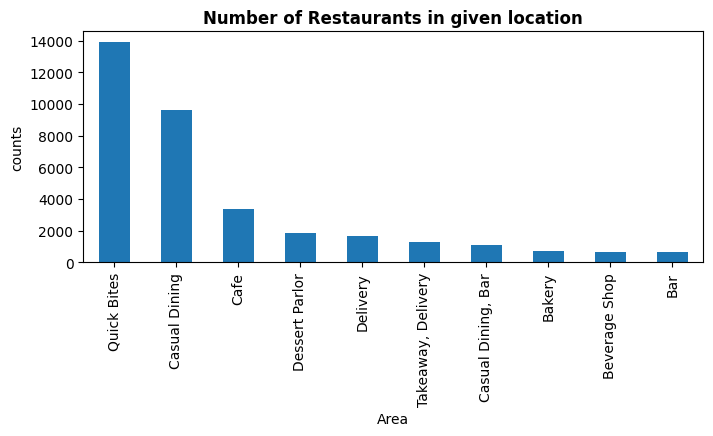

In [305]:
plt.figure(figsize=(8,3))
ax =df4.rest_type.value_counts()[:10].plot(kind='bar')
plt.title('Number of Restaurants in given location', weight='bold')
plt.xlabel('Area')
plt.ylabel('counts')

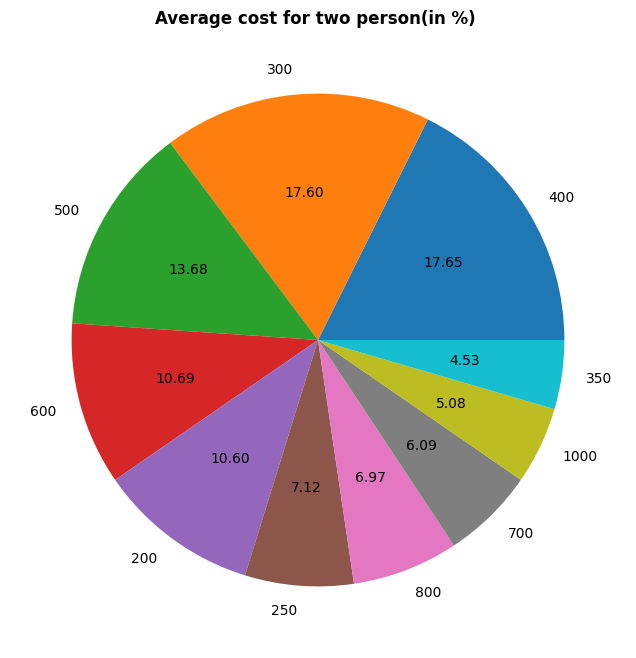

In [ ]:
plt.figure(figsize=(8,8))
values = df4.cost.value_counts().iloc[:10]
labels = df4['cost'].value_counts().iloc[:10].index
plt.pie(values, labels=labels, autopct='%.2f')
plt.title('Average cost for two person(in %) ', weight='bold')
plt.show()

In [306]:
geolocator=Nominatim(user_agent="app")

In [307]:
locations=pd.DataFrame({"Name":df4['location'].unique()})

In [308]:
len(locations)

92

In [309]:
def lonlang(df,columname):
    lat=[]
    lon=[]
    for location in df[columname]:
        location = geolocator.geocode(location)    
        if location is None:
            lat.append(np.nan)
            lon.append(np.nan)
        else:
            lat.append(location.latitude)
            lon.append(location.longitude)
    df['lon'] = lon
    df['lat'] = lat
    

In [310]:
lonlang(locations,'Name')

In [311]:
locations

,Name,lon,lat
0,Banashankari,75.704678,15.887678
1,Basavanagudi,77.575502,12.941726
2,Mysore Road,77.530070,12.946703
3,Jayanagar,83.052805,27.643927
4,Kumaraswamy Layout,77.555318,12.908149
...,...,...,...
87,Jalahalli,77.430522,13.651058
88,Hebbal,77.591900,13.038218
89,Nagarbhavi,77.511267,12.959618
90,Peenya,77.527325,13.032942


#### Brand Loc

In [313]:
df4.type.unique()

array(['Buffet', 'Cafes', 'Delivery', 'Desserts', 'Dine-out',
       'Drinks & nightlife', 'Pubs and bars'], dtype=object)

In [314]:
a= {'name':[],"loca":[],"count":[]}
for b,c in  (df4.groupby(['location'])['name'].value_counts()).items():
    a['name'].append(b[0])
    a['loca'].append(b[1])
    a['count'].append(c)

In [315]:
df4.groupby('rest_type').location.value_counts()

rest_type           location             
Bakery              BTM                      44
                    Sarjapur Road            42
                    Ulsoor                   34
                    JP Nagar                 31
                    Koramangala 1st Block    29
                                             ..
Takeaway, Delivery  Sahakara Nagar            3
                    Sanjay Nagar              3
                    Wilson Garden             3
                    CV Raman Nagar            2
                    West Bangalore            1
Name: location, Length: 1288, dtype: int64

In [316]:
most_rest_loc = (df4.location.value_counts())[:10]

In [317]:
plt.rcParams["figure.figsize"] = (14,8)

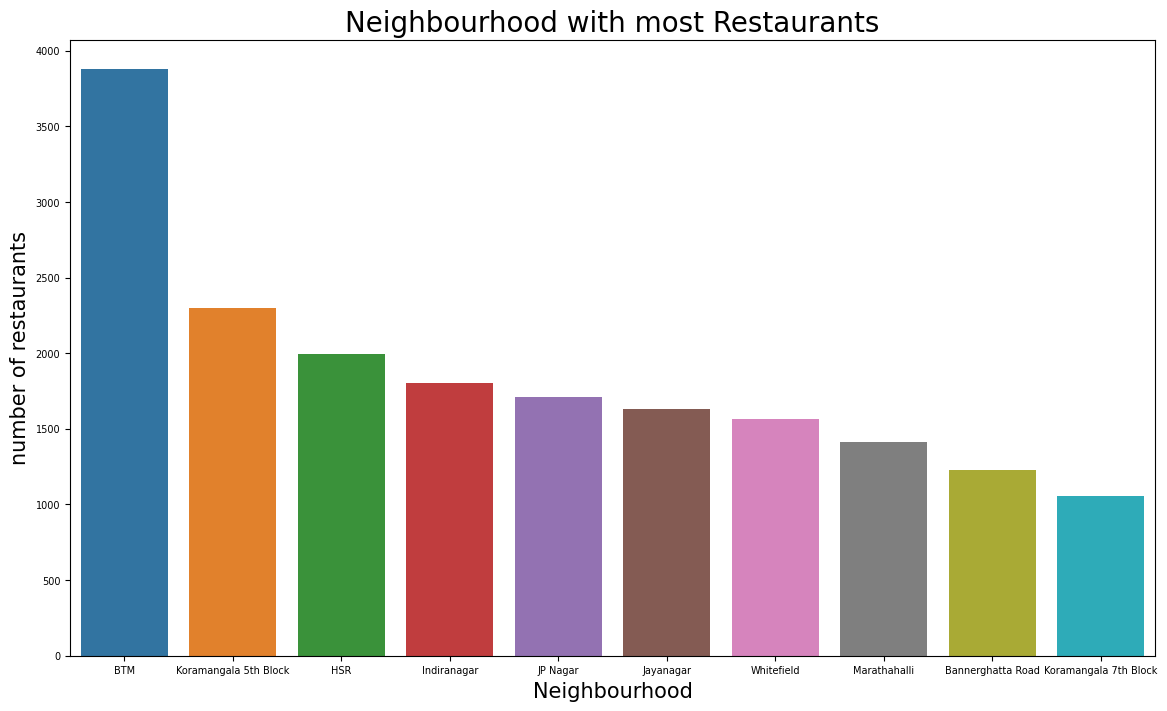

In [318]:
rest_loc = sns.barplot(x=most_rest_loc.keys(),y=most_rest_loc.values,)
rest_loc.axes.set_title("Neighbourhood with most Restaurants",fontsize=20)
rest_loc.set_xlabel("Neighbourhood",fontsize=15)
rest_loc.set_ylabel("number of restaurants",fontsize=15)
rest_loc.tick_params(labelsize=7)


In [ ]:
# brand_loc  = pd.DataFrame(df4['name'].value_counts().reset_index())
# brand_loc.columns=['Name','count']

In [ ]:
brand_loc = pd.DataFrame(a)

In [ ]:
brand_loc

,name,loca,count
0,#FeelTheROLL,Bellandur,2
1,#L-81 Cafe,HSR,9
2,#refuel,Bannerghatta Road,3
3,1000 B.C,Koramangala 5th Block,6
4,100ÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ°C,BTM,3
...,...,...,...
9179,iFruit Live Ice Creams,Koramangala 1st Block,4
9180,iSpice Resto Cafe,Indiranagar,7
9181,nu.tree,Whitefield,4
9182,nu.tree,Sarjapur Road,3


In [ ]:
brands=pd.DataFrame({"Name":df4['name'].unique()})

In [ ]:
brr = brand_loc.copy()

In [ ]:
# lat=[]
# lon=[]
# for location in brands['Name']:
#     location = geolocator.geocode(location)    
#     if location is None:
#         lat.append(np.nan)
#         lon.append(np.nan)
#     else:
#         lat.append(location.latitude)
#         lon.append(location.longitude)
lonlang(brr,'loca')

In [ ]:
for index, row in locations.iterrows():
    if (row['Name'] == brr['loca']).any():
        print(locations['Name'][index])

Banashankari
Basavanagudi
Mysore Road
Jayanagar
Kumaraswamy Layout
Rajarajeshwari Nagar
Vijay Nagar
Uttarahalli
JP Nagar
South Bangalore
City Market
Bannerghatta Road
BTM
Kanakapura Road
Bommanahalli
Electronic City
Wilson Garden
Shanti Nagar
Koramangala 5th Block
Richmond Road
HSR
Koramangala 7th Block
Bellandur
Sarjapur Road
Marathahalli
Whitefield
East Bangalore
Old Airport Road
Indiranagar
Koramangala 1st Block
Frazer Town
MG Road
Brigade Road
Lavelle Road
Church Street
Ulsoor
Residency Road
Shivajinagar
Infantry Road
St. Marks Road
Cunningham Road
Race Course Road
Commercial Street
Vasanth Nagar
Domlur
Koramangala 8th Block
Ejipura
Jeevan Bhima Nagar
Old Madras Road
Seshadripuram
Kammanahalli
Koramangala 6th Block
Majestic
Langford Town
Central Bangalore
Brookefield
ITPL Main Road, Whitefield
Varthur Main Road, Whitefield
Koramangala 2nd Block
Koramangala 3rd Block
Koramangala 4th Block
Koramangala
Hosur Road
RT Nagar
Banaswadi
North Bangalore
Nagawara
Hennur
Kalyan Nagar
HBR Layo

In [ ]:
for i in range(len(brr['loca'])):
    print(locations['lat'].where(brr['loca'] == locations['Name']))

In [ ]:
for i in range(len(brr['loca'])):
    for index, row in locations.iterrows():
        if (row['Name'] == brr['loca']).any():
            # if (brr['loca'][i] == locations['Name']).any():
                brr.loc[brr['loca']==locations['Name'][index],'lat'] == locations['lat'][index]
                brr.loc[brr['loca']==locations['Name'][index],'lon'] == locations['lon'][index]


In [ ]:
brr['lon']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9179    0.0
9180    0.0
9181    0.0
9182    0.0
9183    0.0
Name: lon, Length: 9184, dtype: float64

In [ ]:
# brand_loc=brand_loc.merge(brands,on='Name',how="left").dropna()

In [ ]:
b_map =  generateBaseMap()

In [ ]:

for i in range(0,len(brr)):
   folium.Circle(
      location=[brr.iloc[i]['lat'], brr.iloc[i]['lon']],
      popup=brr.iloc[i]['name'],
      radius=float(brr.iloc[i]['count']),
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(b_map)

# Show the map again
b_map

#### Rest loc

In [ ]:
Rest_locations=pd.DataFrame(df4['location'].value_counts().reset_index())

In [ ]:
Rest_locations.columns=['Name','count']
Rest_locations.head()

,Name,count
0,BTM,3879
1,Koramangala 5th Block,2297
2,HSR,1993
3,Indiranagar,1800
4,JP Nagar,1710


In [ ]:
print(locations.shape)
print(Rest_locations.shape)

(92, 3)
(92, 2)


In [ ]:
Restaurant_locations=Rest_locations.merge(locations,on='Name',how="left").dropna()
Restaurant_locations.head()

,Name,count,lat,lon
0,BTM,3879,45.954851,-112.496595
1,Koramangala 5th Block,2297,12.934843,77.618977
2,HSR,1993,18.147500,41.538889
3,Indiranagar,1800,12.973291,77.640467
4,JP Nagar,1710,12.265594,76.646540


In [ ]:
def generateBaseMap(default_location=[12.97, 77.59], default_zoom_start=12):
    base_map = folium.Map(location=default_location, zoom_start=default_zoom_start)
    return base_map

In [ ]:
basemap=generateBaseMap()

In [ ]:
basemap

In [ ]:
Restaurant_locations[['lat','lon','count']]

,Name,count,lat,lon
0,BTM,3879,45.954851,-112.496595
1,Koramangala 5th Block,2297,12.934843,77.618977
2,HSR,1993,18.147500,41.538889
3,Indiranagar,1800,12.973291,77.640467
4,JP Nagar,1710,12.265594,76.646540
...,...,...,...,...
87,Yelahanka,4,13.100698,77.596345
88,West Bangalore,3,12.984852,77.540063
89,Rajarajeshwari Nagar,2,12.927441,77.515522
90,Nagarbhavi,1,12.959618,77.511267


In [ ]:
HeatMap(Restaurant_locations[['lat','lon','count']],zoom=20,radius=15).add_to(basemap)

In [ ]:
basemap

In [ ]:
FastMarkerCluster(data=Restaurant_locations[['lat','lon','count']].values.tolist()).add_to(basemap)

basemap

#### Location and rate map

In [ ]:
df4.groupby(['location'])['rate'].mean().sort_values(ascending=False)

location
Lavelle Road             4.141788
Koramangala 3rd Block    4.020419
St. Marks Road           4.017201
Koramangala 5th Block    4.006661
Church Street            3.992125
                           ...   
Rammurthy Nagar          3.346154
North Bangalore          3.340000
Peenya                   3.200000
Bommanahalli             3.190972
Old Madras Road          3.181818
Name: rate, Length: 92, dtype: float64

In [ ]:
avg_rating=df4.groupby(['location'])['rate'].mean().values[:10]

In [ ]:
most_rest_loc

BTM                      3879
Koramangala 5th Block    2297
HSR                      1993
Indiranagar              1800
JP Nagar                 1710
Jayanagar                1634
Whitefield               1568
Marathahalli             1410
Bannerghatta Road        1226
Koramangala 7th Block    1055
Name: location, dtype: int64

In [ ]:
loc=df4.groupby(['location'])['rate'].mean().index

In [ ]:
geolocator=Nominatim(user_agent="app")

In [ ]:
df4['rate']

0        4.1
1        4.1
2        3.8
3        3.7
4        3.8
        ... 
41258    3.7
41259    2.5
41260    3.6
41261    4.3
41262    3.4
Name: rate, Length: 41263, dtype: float64

In [ ]:
lat=[]
lon=[]
for location in loc:
    location = geolocator.geocode(location)    
    if location is None:
        lat.append(np.nan)
        lon.append(np.nan)
    else:
        lat.append(location.latitude)
        lon.append(location.longitude)

In [ ]:
rating=pd.DataFrame()
rating['location']=loc
rating['lat']=lat
rating['lon']=lon
rating['avg_rating']=avg_rating

In [ ]:
rating=rating.dropna()

In [ ]:
HeatMap(rating[['lat','lon','avg_rating']],zoom=20,radius=15).add_to(basemap)
basemap

In [ ]:
df2= df4[df4['cuisines']=='North Indian']
df2.head()

,level_0,index,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,reviews_list,menu_item,type,city
5,5,5,"37, 5-1, 4th Floor, Bosco Court, Gandhi Bazaar...",Timepass Dinner,Yes,No,3.8,286,Basavanagudi,Casual Dining,North Indian,600,"[('Rated 3.0', 'RATED\n Food 3/5\nAmbience 3/...",[],Buffet,Banashankari
50,50,50,"276, Ground Floor, 100 Feet Outer Ring Road, B...",Petoo,No,No,3.7,21,Banashankari,Quick Bites,North Indian,450,"[('Rated 2.0', 'RATED\n This is a neatly made...",[],Delivery,Banashankari
85,85,87,"38, 22nd Main, 22nd Cross, Opposite BDA, 2nd S...",Krishna Sagar,No,No,3.5,31,Banashankari,Quick Bites,North Indian,200,"[('Rated 1.0', 'RATED\n Worst experience with...",[],Delivery,Banashankari
90,90,94,"304, Opposite Apollo Public School, 100 Feet R...",Nandhini Deluxe,No,No,2.6,283,Banashankari,Casual Dining,North Indian,600,"[('Rated 3.0', 'RATED\n Ididnt like much.\n\n...",[],Delivery,Banashankari
104,104,109,"8, Katriguppe Main Road, Vivekananda Nagar, 3r...",Katriguppe Donne Biryani,No,No,3.2,4,Banashankari,Quick Bites,North Indian,300,[],[],Delivery,Banashankari


In [ ]:
plt.rcParams["figure.figsize"] = (11,7)

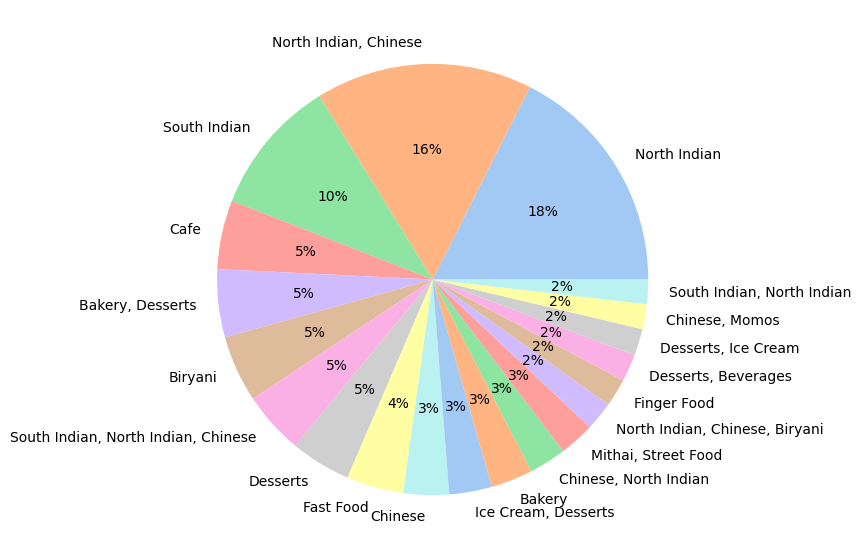

In [ ]:
values = df4['cuisines'].value_counts()[:20]
labels=values.index
text=values.index

colors = sns.color_palette('pastel')[0:len(labels)]
plt.pie(values.values, labels=labels, colors=colors,autopct='%.0f%%')
# displaying chart
plt.show()

<AxesSubplot: xlabel='cost', ylabel='online_order'>

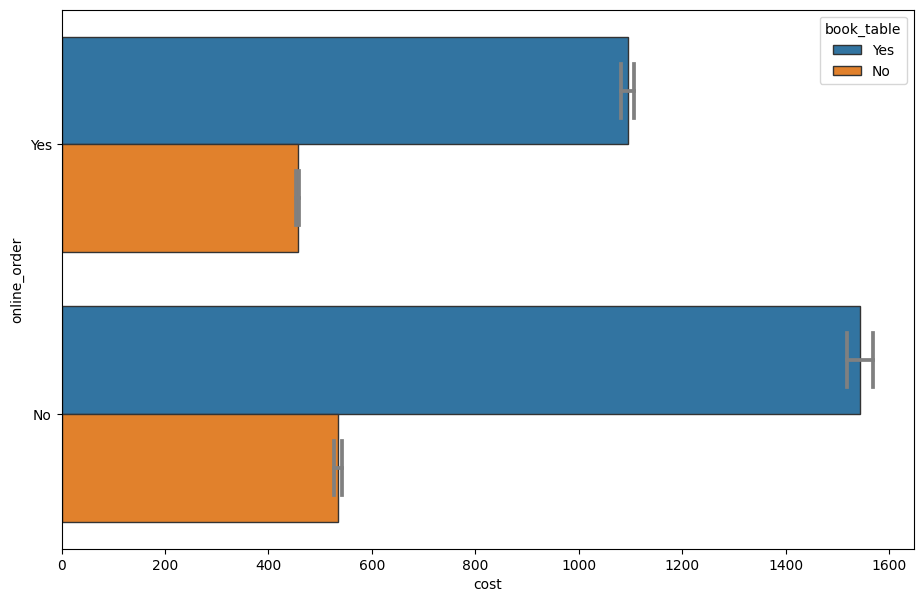

In [ ]:
sns.barplot(df4,x='cost',y='online_order',linewidth=1, edgecolor=".2",capsize=.2, errcolor=".5",orient="h",hue='book_table')
# e expect book table more available on restaurants which doesn't accept online orders

In [ ]:
sns.barplot(df4,x='cost',y='city',orient="h")

NameError: name 'df4' is not defined

#### TYPe insights

In [ ]:
avg_type_rating = df4.groupby('type')['rate'].mean()
avg_type_cost = df4.groupby('type')['cost'].mean()
avg_type = df4.type.unique()

<AxesSubplot: ylabel='cost'>

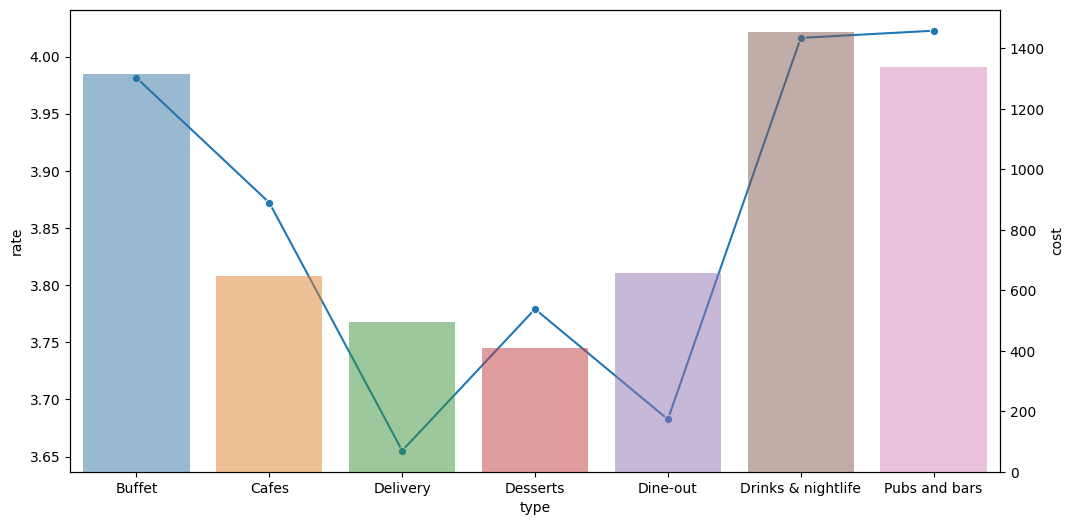

In [ ]:
matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data = avg_type_rating, marker='o', sort = False, ax=ax1)
ax2 = ax1.twinx()

sns.barplot( x=avg_type, y=avg_type_cost, alpha=0.5, ax=ax2)

In [ ]:
df4['rest_type'].value_counts()

Quick Bites                   13885
Casual Dining                  9614
Cafe                           3369
Dessert Parlor                 1850
Delivery                       1667
                              ...  
Food Court, Beverage Shop         2
Dessert Parlor, Food Court        2
Dessert Parlor, Kiosk             2
Bakery, Beverage Shop             1
Quick Bites, Kiosk                1
Name: rest_type, Length: 87, dtype: int64

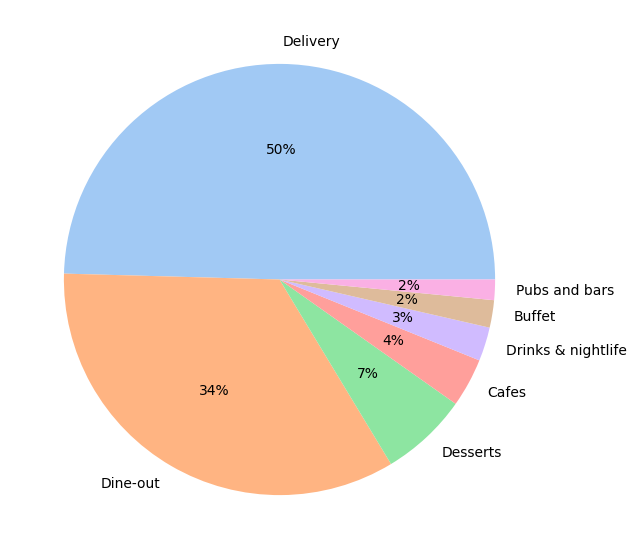

In [ ]:
values = df4['type'].value_counts()
labels=values.index
text=values.index

colors = sns.color_palette('pastel')[0:len(labels)]
plt.pie(values.values, labels=labels, colors=colors,autopct='%.0f%%')
# displaying chart
plt.show()

Text(0.5, 0, 'count')

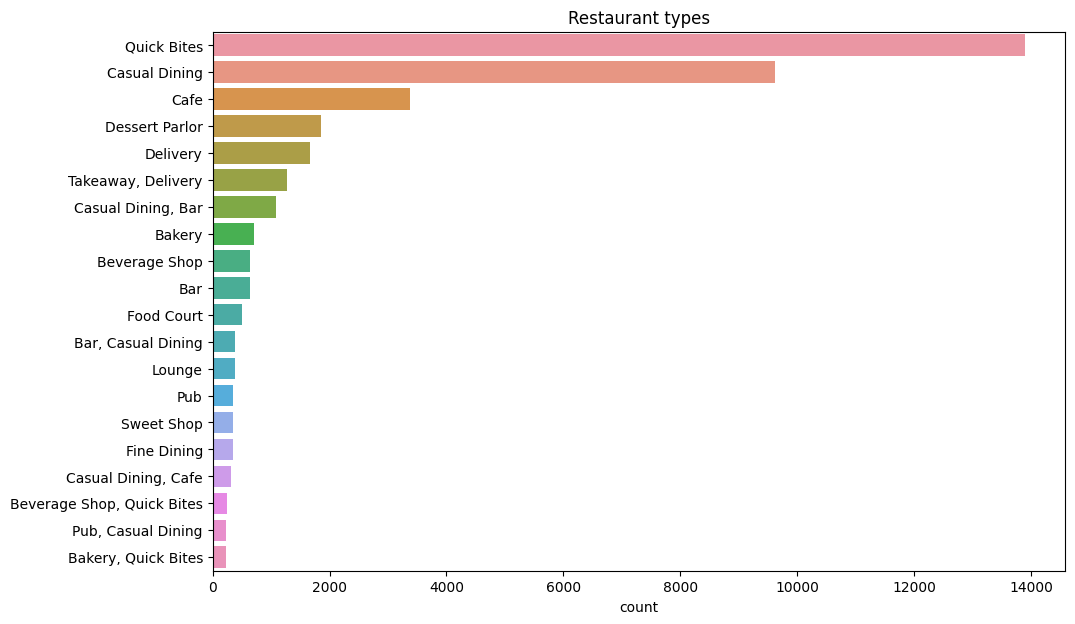

In [ ]:
rest=df4['rest_type'].value_counts()[:20]
sns.barplot(x=rest,y=rest.index)
plt.title("Restaurant types")
plt.xlabel("count")

In [ ]:
df4

,index,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,reviews_list,menu_item,type,city
0,0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,[ A beautiful place to dine in.The interiors...,[],Buffet,Banashankari
1,1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,[ Had been here for dinner with family. Turn...,[],Buffet,Banashankari
2,2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,"[('', ""\n Ambience is not that good enough an...",[],Buffet,Banashankari
3,3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300,"[('', ""\n Great food and proper Karnataka sty...",[],Buffet,Banashankari
4,4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,[ Very good restaurant in neighbourhood. Buf...,[],Buffet,Banashankari
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41258,51709,"136, SAP Labs India, KIADB Export Promotion In...",The Farm House Bar n Grill,No,No,3.7,34,Whitefield,"Casual Dining, Bar","North Indian, Continental",800,[ Ambience- Big and spacious lawn was used t...,[],Pubs and bars,Whitefield
41259,51711,"139/C1, Next To GR Tech Park, Pattandur Agraha...",Bhagini,No,No,2.5,81,Whitefield,"Casual Dining, Bar","Andhra, South Indian, Chinese, North Indian",800,"[ A fine place to chill after office hours, ...",[],Pubs and bars,Whitefield
41260,51712,"Four Points by Sheraton Bengaluru, 43/3, White...",Best Brews - Four Points by Sheraton Bengaluru...,No,No,3.6,27,Whitefield,Bar,Continental,1500,"[('', ""\n Food and service are incomparably e...",[],Pubs and bars,Whitefield
41261,51715,Sheraton Grand Bengaluru Whitefield Hotel & Co...,Chime - Sheraton Grand Bengaluru Whitefield Ho...,No,Yes,4.3,236,"ITPL Main Road, Whitefield",Bar,Finger Food,2500,[ Nice and friendly place and staff is aweso...,[],Pubs and bars,Whitefield


##### REviews and ratings csv creation
We will take reviews_lists seeprate them in a rows. 
Our dataframe will be constitued from review rating and restaurant name, then we will process it with NLP methods 

In [ ]:
all_ratings = []

for name,ratings in tqdm(zip(df2['name'],df2['reviews_list'])):
    ratings = eval(ratings)
    for score, doc in ratings:
        if score:
            score = score.strip("Rated").strip()
            doc = doc.strip('RATED').strip()
            score = float(score)
            all_ratings.append([name,score, doc])
rating_df = pd.DataFrame(all_ratings,columns=['name','rating','review'])
rating_df['review']=rating_df['review'].apply(lambda x : re.sub('[^a-zA-Z0-9\s]',"",x))
rating_df.to_csv("./dbs/ratingsandreviews.csv")

46443it [00:25, 1851.17it/s]


In [ ]:
rating_df.head()

,name,rating,review
0,Jalsa,4.0,A beautiful place to dine inThe interiors take...
1,Jalsa,4.0,I was here for dinner with my family on a week...
2,Jalsa,2.0,Its a restaurant near to Banashankari BDA Me a...
3,Jalsa,4.0,We went here on a weekend and one of us had th...
4,Jalsa,5.0,The best thing about the place is its ambiance...


Text(0.5, 1.0, 'rate vs oline order')

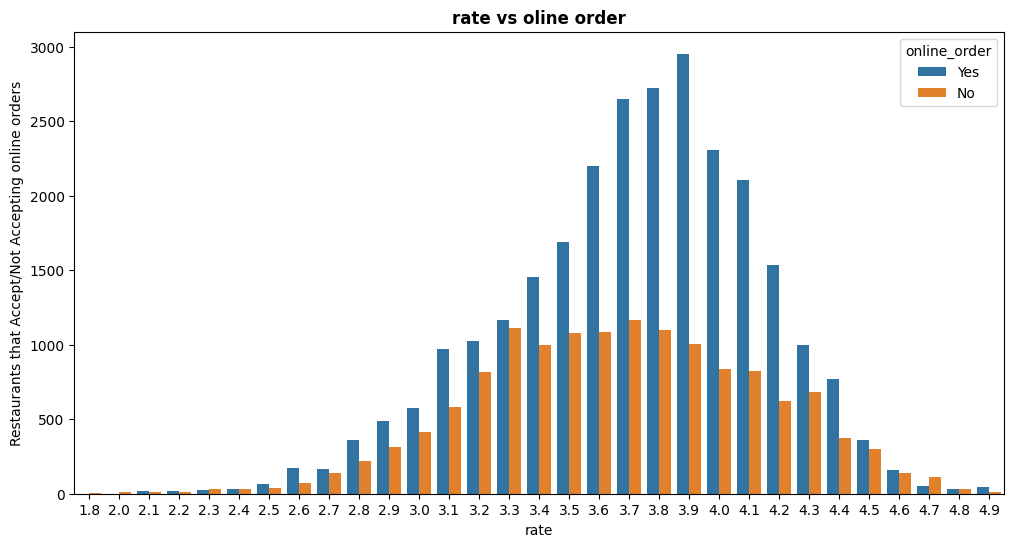

In [ ]:
plt.figure(figsize = (12,6))
sns.countplot(x=df4['rate'], hue = df4['online_order'])
plt.ylabel("Restaurants that Accept/Not Accepting online orders")
plt.title("rate vs oline order",weight = 'bold')

### Model Progress
We will implement our model now

In [323]:
df = pd.read_csv('dbs/zomato.csv')

In [319]:
def one_hot_encode(df, column):
    # Get one hot encoding of columns B
    df[column] = pd.get_dummies(df[column],drop_first=True)


In [320]:
df5 = df.copy()

In [321]:
one_hot_colums = ['book_table','online_order']
for col in one_hot_colums:
    one_hot_encode(df5,col)

In [324]:
df5.columns

Index(['level_0', 'index', 'name', 'online_order', 'book_table', 'rate',
       'votes', 'location', 'rest_type', 'dish_liked', 'cuisines', 'cost',
       'reviews_list', 'menu_item', 'type', 'city'],
      dtype='object')

In [ ]:
unnec_columns=['reviews_list','menu_item','address','type','url','phone','listed_in(city)']

In [ ]:
def drop_unnecs(df,columns):
    for col in columns:
        if col in df.columns:

            df.drop(col,axis=1,inplace=True)
    return df

In [ ]:
drop_unnecs(df5,unnec_columns)

In [ ]:
df5.columns

Index(['name', 'online_order', 'book_table', 'rate', 'votes', 'location',
       'rest_type', 'cuisines', 'approx_cost(for two people)'],
      dtype='object')

In [ ]:
df5.dropna(inplace=True)

In [ ]:
# df5.drop(columns=['dish_liked','listed_in(type)'], inplace  = True)

In [ ]:
df5['rest_type'] = df5['rest_type'].str.replace(',' , '') 
df5['rest_type'] = df5['rest_type'].astype(str).apply(lambda x: ' '.join(sorted(x.split())))
df5['rest_type'].value_counts().head()

Bites Quick       15011
Casual Dining      9878
Cafe               3491
Dessert Parlor     1925
Delivery           1777
Name: rest_type, dtype: int64

In [ ]:
df6  = df5.copy()

In [ ]:
df5 = df5.loc[df5.rate !='NEW']
df5 = df5.loc[df5.rate !='-'].reset_index(drop=True)
remove_slash = lambda x: x.replace('/5', '') if type(x) == np.str else x
df5.rate = df5.rate.apply(remove_slash).str.strip().astype('float')
df5['rate'].head()

C:\Users\emreb\AppData\Local\Temp\ipykernel_20628\1665189581.py:3: DeprecationWarning:

`np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
Name: rate, dtype: float64

In [ ]:
df5.reset_index(drop=True)

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people)
0,Jalsa,1,1,4.1,775,Banashankari,Casual Dining,Chinese Indian Mughlai North,800
1,Spice Elephant,1,0,4.1,787,Banashankari,Casual Dining,Chinese Indian North Thai,800
2,San Churro Cafe,1,0,3.8,918,Banashankari,Cafe Casual Dining,Cafe Italian Mexican,800
3,Addhuri Udupi Bhojana,0,0,3.7,88,Banashankari,Bites Quick,Indian Indian North South,300
4,Grand Village,0,0,3.8,166,Basavanagudi,Casual Dining,Indian North Rajasthani,600
...,...,...,...,...,...,...,...,...,...
41405,The Farm House Bar n Grill,0,0,3.7,34,Whitefield,Bar Casual Dining,Continental Indian North,800
41406,Bhagini,0,0,2.5,81,Whitefield,Bar Casual Dining,Andhra Chinese Indian Indian North South,800
41407,Best Brews - Four Points by Sheraton Bengaluru...,0,0,3.6,27,Whitefield,Bar,Continental,1500
41408,Chime - Sheraton Grand Bengaluru Whitefield Ho...,0,1,4.3,236,"ITPL Main Road, Whitefield",Bar,Finger Food,2500


In [ ]:
df5['cuisines'] = df5['cuisines'].str.replace(',' , '') 
df5['cuisines'] = df5['cuisines'].astype(str).apply(lambda x: ' '.join(sorted(x.split())))
df5['cuisines'].value_counts().head()

Chinese Indian North                 2317
Indian North                         2118
Indian South                         1232
Chinese Indian Indian North South    1059
Bakery Desserts                       777
Name: cuisines, dtype: int64

In [ ]:
# df5['approx_cost(for two people)'] = df5['approx_cost(for two people)'].str.replace(',' , '') 
# df5['approx_cost(for two people)'] = df5['approx_cost(for two people)'].apply(int)

In [ ]:
x = df5.drop(['rate','name'],axis = 1)
y = df5['rate']

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from joblib import dump,load

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 42)

In [ ]:
# save to local disk
dump(X_train, 'dbs/pkl/more_feature_X_train')
dump(X_test, 'dbs/pkl/more_feature_X_test')
dump(y_train, 'dbs/pkl/more_feature_y_train')
dump(y_test, 'dbs/pkl/more_feature_y_test')

['dbs/pkl/more_feature_y_test']

In [ ]:
X_train = load('dbs/pkl/more_feature_X_train')
X_test = load('dbs/pkl/more_feature_X_test')
y_train = load('dbs/pkl/more_feature_y_train')
y_test = load('dbs/pkl/more_feature_y_test')

In [ ]:
one_enc = OneHotEncoder( handle_unknown='ignore')

In [ ]:
def one_hot_fit_transform(df,name):
    output_data = df[name].values.reshape(-1, 1)
    return one_enc.fit_transform(output_data).toarray()

# this method is for test data set
def one_hot_transform(df,name):
    output_data1 = df[name].values.reshape(-1, 1)
    return one_enc.transform(output_data1).toarray()

In [ ]:
tr_dummy_rest_type = one_hot_fit_transform(X_train,'rest_type' )
te_dummy_rest_type= one_hot_transform(X_test,'rest_type' )

# one hot encoding apply to 'location' features on train/test dataset
tr_dummy_city = one_hot_fit_transform(X_train,'location' )
te_dummy_city= one_hot_transform(X_test,'location')

# one hot encoding apply to 'cuisines' features on train/test dataset
tr_dummy_cuisines = one_hot_fit_transform(X_train,'cuisines' )
te_dummy_cuisines=one_hot_transform(X_test,'cuisines')

In [ ]:
tr =pd.DataFrame(np.column_stack([ tr_dummy_rest_type,tr_dummy_city, tr_dummy_cuisines]))

## CONCAT both dataframe ### ie Tr and X_train(original dataframe)
## https://stackoverflow.com/questions/45963799/pandas-concat-resulting-in-nan-rows

l1=X_train.values.tolist()
l2=tr.values.tolist()

for i in range(len(l1)):
    l1[i].extend(l2[i])

X_train=pd.DataFrame(l1,columns=X_train.columns.tolist()+tr.columns.tolist())
X_train.shape

(33128, 1833)

In [ ]:
te =pd.DataFrame(np.column_stack([ te_dummy_rest_type,te_dummy_city,te_dummy_cuisines]))

## CONCAT both dataframe ### ie Te and X_test(original dataframe)
## https://stackoverflow.com/questions/45963799/pandas-concat-resulting-in-nan-rows

l3=X_test.values.tolist()
l4=te.values.tolist()
for i in range(len(l3)):
    l3[i].extend(l4[i])

X_test=pd.DataFrame(l3,columns=X_test.columns.tolist()+te.columns.tolist())
X_test.shape

(8282, 1833)

In [ ]:
X_train =X_train.drop(['location','rest_type','cuisines',],axis = 1)
X_test =X_test.drop(['location','rest_type','cuisines',],axis = 1)

In [ ]:
dump(X_train, 'dbs/max_features/more_feature_X_train')
dump(X_test, 'dbs/max_features/more_feature_X_test')
dump(y_train, 'dbs/max_features/more_feature_y_train')
dump(y_test, 'dbs/max_features/more_feature_y_test')

['dbs/max_features/more_feature_y_test']

In [ ]:
X_train= load('dbs/max_features/more_feature_X_train') 
X_test= load('dbs/max_features/more_feature_X_test')
y_train= load('dbs/max_features/more_feature_y_train')
y_test= load('dbs/max_features/more_feature_y_test')

In [ ]:
def mse(y, y_pred):
    return np.mean((y_pred - y)**2) 

mse_scorer = make_scorer(mse, greater_is_better=False)

In [ ]:
import random

In [ ]:
rand_pred= np.zeros(y_test.shape[0])
for i in range(y_test.shape[0]):
    rand_probs = round(random.uniform(1.0, 5.0),2)
    rand_pred[i] = rand_probs

mse(y_test, rand_pred)

2.01723304757305

In [ ]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)

mse(y_test, y_pred_lr)

c:\Users\emreb\Documents\projects\datavisu\datavisuenv\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

c:\Users\emreb\Documents\projects\datavisu\datavisuenv\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



622177701557.1898

In [ ]:
sgdReg = linear_model.SGDRegressor()
sgdReg.fit(X_train,y_train)
y_pred_sgdr = sgdReg.predict(X_test)

mse(y_test, y_pred_sgdr)

c:\Users\emreb\Documents\projects\datavisu\datavisuenv\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

c:\Users\emreb\Documents\projects\datavisu\datavisuenv\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



7.954136034431229e+29

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
y_pred_rfr = rfr.predict(X_test)

mse(y_test, y_pred_rfr)

c:\Users\emreb\Documents\projects\datavisu\datavisuenv\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

c:\Users\emreb\Documents\projects\datavisu\datavisuenv\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



0.012160244513044463

In [ ]:
# tuned_parameters = {'n_estimators': [250,500,1000,1200]}

# grd_regressor = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=10, 
#                    n_jobs=-1, verbose=1, scoring=mse_scorer)
# grd_regressor.fit(X_train, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [ ]:
rfr = RandomForestRegressor(max_depth=None,n_estimators=200,min_samples_split= 2)
rfr.fit(X_train,y_train)
y_pred_rfr = rfr.predict(X_test)

mse(y_test, y_pred_rfr)

In [ ]:
Randpred = pd.DataFrame({ "actual": y_test, "pred": y_pred_rfr })
Randpred

In [ ]:
GridSearchCV()